In [104]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import eigs
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [105]:
params = {
    'waveguide': {
        'core_width' : 450e-9,
        'core_height' : 220e-9,
        'n_Si': 3.48,
        'n_SiO2': 1.44,
    },
    'domain': {
        'width': 8e-6,
        'height': 6e-6,
        'dx': 10e-9,
        'dy': 10e-9,
    },
    'solver': {
        'n_modes': 3,
        'window_decay_rate': 3.0,
        'boundary_width': 1.5e-6,
    },
    'wavelength': {
        'center': 1550e-9,
        'sweep_min': 1450e-9,
        'sweep_max': 1650e-9,
        'sweep_points': 3,
    },
    'sweep': {
        'dx': 15.0e-9,
        'dy': 15.0e-9,
        'n_modes': 3,
    },
    'plot': {
        'field_cmap': 'hot',
        'xlim': (-4., 4.),
        'ylim': (-3., 3.),
        'figsize': (15, 4),
        'dpi': 300,
    }
}


In [106]:
# def second_derivative_1d(n, d):
#     main = -2 * np.ones(n)
#     off = np.ones(n - 1)
#     return sp.diags([off, main, off], offsets=[-1, 0, 1]) / d**2
#
# def build_laplacian_2d(nx, ny, dx, dy):
#     Dxx = second_derivative_1d(nx, dx)
#     Dyy = second_derivative_1d(ny, dy)
#     Ix = sp.eye(nx)
#     Iy = sp.eye(ny)
#     return sp.kron(Dxx, Iy) + sp.kron(Ix, Dyy)

def first_derivative_1d(n, d):
    """Central-difference 1D derivative matrix (size n×n, spacing d)."""
    off = 0.5 / d
    data = [-off * np.ones(n-1), np.zeros(n), off * np.ones(n-1)]
    return sp.diags(data, offsets=[-1, 0, 1])

def build_derivative_operators(nx, ny, dx, dy):
    """
    Returns two sparse matrices Dx, Dy of shape (nx*ny, nx*ny) that
    approximate ∂/∂x and ∂/∂y on a tensor grid.
    """
    Dx1 = first_derivative_1d(nx, dx)
    Dy1 = first_derivative_1d(ny, dy)
    Dx = sp.kron(Dx1, sp.eye(ny))   # ∂/∂x acting on flattened column-major grid
    Dy = sp.kron(sp.eye(nx), Dy1)   # ∂/∂y
    return Dx, Dy


In [107]:
# def wavelength_sweep(core_width, core_height, n_core, n_clad, wavelengths, n_modes=2, params=None):
#     width = params['domain']['width']
#     height = params['domain']['height']
#     dx = params['domain']['dx']
#     dy = params['domain']['dy']
#
#     te_n_effs = np.full((len(wavelengths), n_modes), np.nan, dtype=complex)
#     tm_n_effs = np.full((len(wavelengths), n_modes), np.nan, dtype=complex)
#
#     for i, wl in enumerate(wavelengths):
#         print(f"Solving for wavelength {wl * 1e9:.1f} nm")
#         solver = WaveguideModeSolver(width, height, dx, dy, wl, n_modes=n_modes, params=params)
#         solver.add_rectangle(-core_width / 2, core_width / 2, -core_height / 2, core_height / 2,
#                              n_core, n_clad)
#
#         neffs = solver.solve()
#         te = neffs['TE']
#         tm = neffs['TM']
#
#         for j in range(min(len(te), n_modes)):
#             te_n_effs[i, j] = np.real(te[j])
#         for j in range(min(len(tm), n_modes)):
#             tm_n_effs[i, j] = np.real(tm[j])
#
#     return wavelengths, te_n_effs, tm_n_effs

def wavelength_sweep(core_width, core_height, n_core, n_clad, wavelengths, n_modes=2, params=None):
    width  = params['domain']['width']
    height = params['domain']['height']
    dx     = params['domain']['dx']
    dy     = params['domain']['dy']

    # single array, not separate TE/TM
    n_effs = np.full((len(wavelengths), n_modes), np.nan)

    for i, wl in enumerate(wavelengths):
        print(f"Solving for wavelength {wl*1e9:.1f} nm")
        solver = WaveguideModeSolver(width, height, dx, dy, wl, n_modes=n_modes, params=params)
        solver.add_rectangle(-core_width/2, core_width/2, -core_height/2, core_height/2,
                             n_core, n_clad)

        neffs = solver.solve()            # now returns 1D array
        for j in range(min(len(neffs), n_modes)):
            n_effs[i, j] = np.real(neffs[j])

    return wavelengths, n_effs



In [108]:
class WaveguideModeSolver:
    def __init__(self, width, height, dx, dy, wavelength, n_modes, params):
        self.width = width
        self.height = height
        self.dx = dx
        self.dy = dy
        self.wavelength = wavelength
        self.n_modes = n_modes
        self.params = params
        self.epsilon0 = 8.8541878128e-12
        self.c = 299792458.0
        self.mu0 = 4e-7 * np.pi

        self.nx = int(width/self.dx)
        self.ny = int(height/self.dy)

        self.Dx, self.Dy = build_derivative_operators(self.nx, self.ny, self.dx, self.dy)
        self.k0 = 2 * np.pi / self.wavelength

        self.epsilon_r = np.ones((self.ny, self.nx))

        self.x = np.linspace(-self.width/2, self.width/2, self.nx)
        self.y = np.linspace(-self.height/2, self.height/2, self.ny)
        self.xx, self.yy = np.meshgrid(self.x, self.y)


    def add_rectangle(self, x_min, x_max, y_min, y_max, n_core, n_clad):
        i_min = int((x_min + self.width/2) / self.dx)
        i_max = int((x_max + self.width/2) / self.dx)
        j_min = int((y_min + self.height/2) / self.dy)
        j_max = int((y_max + self.height/2) / self.dy)

        i_min = max(0, i_min)
        i_max = min(self.nx, i_max)
        j_min = max(0, j_min)
        j_max = min(self.ny, j_max)

        self.epsilon_r[:, :] = n_clad ** 2
        self.epsilon_r[j_min:j_max, i_min:i_max] = n_core ** 2


    # def normalize_TE_mode(self, Ex, Ey, epsilon_r, dx, dy):
    #     epsilon = self.epsilon0 * epsilon_r  # physical permittivity
    #     intensity = epsilon * (np.abs(Ex)**2 + np.abs(Ey)**2)
    #     power = np.sum(intensity) * dx * dy
    #     scale = 1.0 / np.sqrt(power)
    #     return Ex * scale, Ey * scale
    #
    # def normalize_TM_mode(self, Ez, epsilon_r, dx, dy):
    #     # For TM, power ~ (1/2) Re(Ez * H*_φ) but approximate with |Ez|^2 weighted
    #     intensity = self.epsilon0 * epsilon_r * np.abs(Ez)**2
    #     power = np.sum(intensity) * dx * dy
    #     scale = 1.0 / np.sqrt(power)
    #     return Ez * scale
    # def filter_modes(self, n_eff_array, eigvecs, n_clad, margin=1e-3, imag_tol=1e-3):
    #     """
    #     Keeps modes with Re(n_eff) > n_clad + margin and small imaginary part,
    #     returns filtered & sorted (by decreasing real part) n_eff and eigvecs.
    #     """
    #     real = np.real(n_eff_array)
    #     imag = np.imag(n_eff_array)
    #     mask = (real > n_clad + margin) & (np.abs(imag) < imag_tol)
    #     if np.count_nonzero(mask) == 0:
    #         return np.array([], dtype=complex), np.zeros((eigvecs.shape[0], 0), dtype=complex)
    #     filtered_n = n_eff_array[mask]
    #     filtered_eigvecs = eigvecs[:, mask]
    #     order = np.argsort(-np.real(filtered_n))  # descending real part
    #     return filtered_n[order], filtered_eigvecs[:, order]

    def solve(self, target_delta=0.03):
        """
        Solve the full-vector 2D Maxwell eigenproblem (curl-curl) for guided modes.
        Populates self.n_eff, self.E_fields, self.Hz_fields, and self.energy_density.
        Returns:
            self.n_eff (array of guided effective indices)
        """
        # --- constants and grid ---
        c    = self.c
        mu0  = self.mu0
        eps0 = self.epsilon0
        omega = 2 * np.pi * c / self.wavelength
        k0    = self.k0
        nx, ny = self.nx, self.ny
        N      = nx * ny

        # --- material params ---
        eps_r    = self.epsilon_r
        eps_phys = (eps0 * eps_r).flatten()
        n_core   = np.sqrt(np.max(eps_r))
        n_clad   = np.sqrt(np.min(eps_r))

        # --- build curl-curl operator A and mass matrix B ---
        Dx, Dy = self.Dx, self.Dy
        L  = (1.0/mu0) * (Dx @ Dx + Dy @ Dy)
        A11 = L - (k0**2) * sp.diags(eps_phys)
        A = sp.bmat([[A11, None],
                     [None, A11]], format="csr")
        B = sp.bmat([[sp.diags(eps_phys), None],
                     [None, sp.diags(eps_phys)]], format="csr")

        # --- solve generalized eigenproblem A x = λ B x for β² eigenvalues ---
        sigma = ((n_core - target_delta) * k0)**2
        eigvals, eigvecs = eigs(A, M=B, k=self.n_modes, sigma=sigma, which='LM')

        # --- extract effective indices and sort ---
        beta   = np.sqrt(eigvals)
        n_effs = beta / k0
        order  = np.argsort(-np.real(n_effs))
        n_effs = n_effs[order]
        eigvecs = eigvecs[:, order]

        # --- keep only guided modes (n_eff > n_clad + margin), with fallback if none ---
        mask = np.real(n_effs) > n_clad + target_delta
        guided_indices = np.where(mask)[0]
        if guided_indices.size == 0:
            # no modes passed the threshold → take the top n_modes anyway
            guided_indices = np.arange(min(self.n_modes, len(n_effs)))
        else:
            guided_indices = guided_indices[: self.n_modes]
        self.n_eff = n_effs[guided_indices]

        # --- reshape into Ex, Ey ---
        self.E_fields = []
        for idx in guided_indices:
            vec = eigvecs[:, idx]
            Ex = vec[:N].reshape(ny, nx)
            Ey = vec[N:].reshape(ny, nx)
            self.E_fields.append((Ex, Ey))

        # --- reconstruct Hz and compute energy density ---
        self.Hz_fields      = []
        self.energy_density = []
        for Ex, Ey in self.E_fields:
            dEy_dx = np.gradient(Ey, self.dx, axis=1)
            dEx_dy = np.gradient(Ex, self.dy, axis=0)
            Hz = (1.0/(1j * omega * mu0)) * (dEy_dx - dEx_dy)
            self.Hz_fields.append(Hz)

            electric = 0.5 * eps0 * eps_r * (np.abs(Ex)**2 + np.abs(Ey)**2)
            magnetic = 0.5 * mu0  * (np.abs(Hz)**2)
            self.energy_density.append(electric + magnetic)

        return self.n_eff


    def plot_vectorial_mode(self, mode_idx, title_suffix=""):
        """
        Plot Ex, Ey, Hz and total energy density W for mode `mode_idx`.
        """
        Ex, Ey = self.E_fields[mode_idx]
        Hz    = self.Hz_fields[mode_idx]
        W     = self.energy_density[mode_idx]

        # Convert to µm for axes
        X = self.x * 1e6
        Y = self.y * 1e6
        extent = [X[0], X[-1], Y[0], Y[-1]]

        fig, axs = plt.subplots(2, 2, figsize=(10, 8))

        im0 = axs[0,0].imshow(np.real(Ex), extent=extent, origin='lower', cmap='RdBu')
        axs[0,0].set_title(f"Re(Ex) {title_suffix}")
        plt.colorbar(im0, ax=axs[0,0])

        im1 = axs[0,1].imshow(np.real(Ey), extent=extent, origin='lower', cmap='RdBu')
        axs[0,1].set_title(f"Re(Ey) {title_suffix}")
        plt.colorbar(im1, ax=axs[0,1])

        im2 = axs[1,0].imshow(np.abs(Hz), extent=extent, origin='lower', cmap='inferno')
        axs[1,0].set_title(f"|Hz| {title_suffix}")
        plt.colorbar(im2, ax=axs[1,0])

        im3 = axs[1,1].imshow(W, extent=extent, origin='lower', cmap='plasma')
        axs[1,1].set_title(f"Energy density W {title_suffix}")
        plt.colorbar(im3, ax=axs[1,1])

        for ax in axs.flat:
            ax.set_xlabel('x (µm)')
            ax.set_ylabel('y (µm)')

        plt.tight_layout()
        plt.show()

    # def plot_TE_mode(self, mode_idx, wavelength, n_eff):
    #     Ex, Ey = self.E_TE[mode_idx]
    #     intensity = np.abs(Ex)**2 + np.abs(Ey)**2
    #     fig, ax = plt.subplots(1, 1, figsize=(5,4))
    #     im = ax.imshow(intensity,
    #                    extent=[-self.width/2*1e6, self.width/2*1e6, -self.height/2*1e6, self.height/2*1e6],
    #                    origin='lower', cmap='inferno')
    #     ax.set_title(f"TE mode {mode_idx}, n_eff={np.real(n_eff):.6f} @ {wavelength*1e9:.0f}nm")
    #     ax.set_xlabel('x (µm)'); ax.set_ylabel('y (µm)')
    #     plt.colorbar(im, label='|E|^2')
    #     # optional vector overlay (downsample for clarity)
    #     skip = max(1, int(self.nx / 40))
    #     X, Y = np.meshgrid(self.x*1e6, self.y*1e6)
    #     ax.quiver(X[::skip, ::skip], Y[::skip, ::skip],
    #               np.real(Ex)[::skip, ::skip], np.real(Ey)[::skip, ::skip],
    #               scale=50, width=0.003)
    #     plt.tight_layout()
    #     plt.xlim(self.params['plot']['xlim'][0], self.params['plot']['xlim'][1])
    #     plt.ylim(self.params['plot']['ylim'][0], self.params['plot']['ylim'][1])
    #     plt.show()
    #
    # def plot_TM_mode(self, mode_idx, wavelength, n_eff):
    #     Ez = self.Ez_modes[mode_idx]
    #     Hx, Hy = self.H_TM[mode_idx]
    #     intensity = np.abs(Ez)**2
    #     fig, axs = plt.subplots(1, 2, figsize=(10,4))
    #     im0 = axs[0].imshow(np.abs(Ez),
    #                         extent=[-self.width/2*1e6, self.width/2*1e6, -self.height/2*1e6, self.height/2*1e6],
    #                         origin='lower', cmap='inferno')
    #     axs[0].set_title(f"TM Ez mode {mode_idx}, n_eff={np.real(n_eff):.6f}")
    #     axs[0].set_xlabel('x (µm)'); axs[0].set_ylabel('y (µm)')
    #     plt.colorbar(im0, ax=axs[0], label='|E_z|')
    #
    #     im1 = axs[1].imshow(np.abs(Hx)**2 + np.abs(Hy)**2,
    #                         extent=[-self.width/2*1e6, self.width/2*1e6, -self.height/2*1e6, self.height/2*1e6],
    #                         origin='lower', cmap='viridis')
    #     axs[1].set_title("Magnetic intensity |H|^2")
    #     axs[1].set_xlabel('x (µm)'); axs[1].set_ylabel('y (µm)')
    #     plt.colorbar(im1, ax=axs[1], label='|H|^2')
    #     plt.tight_layout()
    #     plt.show()

In [109]:
def main():
    # Extract parameters
    core_width = params['waveguide']['core_width']
    core_height = params['waveguide']['core_height']
    n_Si = params['waveguide']['n_Si']
    n_SiO2 = params['waveguide']['n_SiO2']

    width = params['domain']['width']
    height = params['domain']['height']
    dx = params['domain']['dx']
    dy = params['domain']['dy']

    wl_min = params['wavelength']['sweep_min']
    wl_max = params['wavelength']['sweep_max']
    wl_points = params['wavelength']['sweep_points']

    n_modes = params['sweep']['n_modes']

    # # Create wavelength sweep
    # wavelengths = np.linspace(wl_min, wl_max, wl_points)
    #
    # # Perform sweep
    # wl_sweep, te_n_effs, tm_n_effs = wavelength_sweep(core_width, core_height, n_Si, n_SiO2, wavelengths, n_modes=n_modes, params=params)
    # # Plot the fundamental vectorial mode at 1310 nm and 1550 nm
    # for wl in [1310e-9, 1550e-9]:
    #     solver = WaveguideModeSolver(width, height, dx, dy, wl, n_modes=1, params=params)
    #     solver.add_rectangle(-core_width/2, core_width/2, -core_height/2, core_height/2, n_Si, n_SiO2)
    #     _ = solver.solve()
    #     solver.plot_vectorial_mode(0, title_suffix=f"n_eff={solver.n_eff[0].real:.6f} @ {wl*1e9:.0f} nm")
    # # center wavelength for mode profiles
    # solver = WaveguideModeSolver(width, height, dx, dy, 1550e-9, n_modes=2, params=params)
    # solver.add_rectangle(-core_width / 2, core_width / 2,
    #                      -core_height / 2, core_height / 2,
    #                      n_Si, n_SiO2)

    # Create and run the sweep
    wavelengths = np.linspace(wl_min, wl_max, wl_points)
    wl_sweep, n_effs_sweep = wavelength_sweep(core_width, core_height,
                                             n_Si, n_SiO2,
                                             wavelengths,
                                             n_modes=n_modes,
                                             params=params)

    # Plot effective-index curves for the first two modes
    plt.figure()
    plt.plot(wl_sweep * 1e9, n_effs_sweep[:, 0], label='mode 0')
    plt.plot(wl_sweep * 1e9, n_effs_sweep[:, 1], label='mode 1')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Effective index')
    plt.legend()
    plt.grid(True)
    plt.title('First two guided modes')
    plt.tight_layout()
    plt.show()

    # Plot the vectorial fields at specific wavelengths
    for wl in [1310e-9, 1550e-9]:
        solver = WaveguideModeSolver(width, height, dx, dy, wl, n_modes=2, params=params)
        solver.add_rectangle(-core_width/2, core_width/2, -core_height/2, -core_height/2 + core_height,
                             n_Si, n_SiO2)
        neffs = solver.solve()
        solver.plot_vectorial_mode(0, title_suffix=f"n_eff={neffs[0].real:.6f} @ {wl*1e9:.0f}nm")
    # # Plot effective index curves
    # plt.figure()
    # plt.plot(wl_sweep * 1e9, te_n_effs[:, 0].real, label='TE0')
    # plt.plot(wl_sweep * 1e9, tm_n_effs[:, 0].real, label='TM0')
    # plt.xlabel('Wavelength (nm)')
    # plt.ylabel('Effective index')
    # plt.legend()
    # plt.grid(True)
    # plt.title('Fundamental TE0/TM0 effective indices')
    # plt.tight_layout()
    # plt.show()


Solving for wavelength 1450.0 nm
Solving for wavelength 1550.0 nm
Solving for wavelength 1650.0 nm


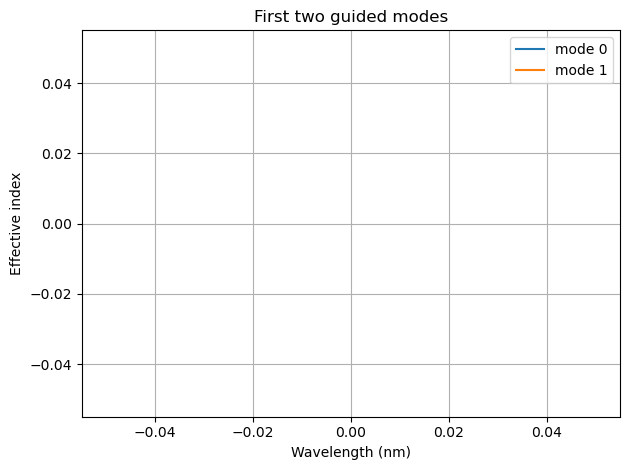

IndexError: index 0 is out of bounds for axis 0 with size 0

In [110]:
main()